# Test case 03 benchmark DLFT vs WR



![TC_03](./_images/TC_03.PNG "TC_03")



| $m_{j}$ | $c_{j}$ | $k_{j}$ | $\mu N$| $F_{ext}$| $N$|
|:-:|:-:|:-:|:-:|:-:|:-:|
| $1$ | $1$ | $1$ | $0.3^{2}$ | $0.1$ | $\{ 14, 40, 90, 290 \}$ |

In [1]:
# make generic imports 
import pyHarm
import numpy as np
from HelperFunctions import prep_fig, export_sol, get_frf, create_directory_relative, modify_input_dict, build_style, mid, spectral_radius_dynamicMat
import copy 
NAME_STUDY = "TC_03"
create_directory_relative(NAME_STUDY)

from pyHarm.BaseUtilFuncs import pyHarm_plugin
from CustomDLFTFriction import DLFTFriction
pyHarm_plugin(DLFTFriction)


Directory 'TC_03' created or already exists.


In [2]:
# Brut data from drawings
m = 1e0
k = 1e0
c = 1e0
mu, N0 = 0.3, 0.3
Fext = 0.1
epsilon_dlft =1e0

List_N_masses = [15, 40, 90, 290]
N_masses = List_N_masses[0]
Ntot_masses = N_masses + 10
## let's build the matrices 
M = np.diag(np.array(
    [m]*(Ntot_masses)
))
nrow,ncol = M.shape
BandMat = np.zeros(M.shape)
BandMat[np.arange(nrow), np.arange(ncol)] = 2
BandMat[np.arange(nrow-1), np.arange(ncol-1)+1] = -1
BandMat[np.arange(nrow-1)+1, np.arange(ncol-1)] = -1
BandMat[-1,-1] = 1
K = copy.deepcopy(BandMat)
K *= k
C = copy.deepcopy(BandMat)
C *= c
G = 0*K


# Let's construct everything for the system to be built : 
sub_dict = dict(
    type='substructure',
    ndofs=1,
    matrix = dict(
        M = M,
        C = C,
        G = G,
        K = K
    )
)
loading = dict(
        type='CosinusForcing',
        connect=dict(sub=[Ntot_masses-1]),
        dirs=[0],
        amp = Fext
)


friction_dict = dict()
for k in range(N_masses) : 
    friction_dict[f'{k:03d}'] = dict(
            type='DLFTFriction',
            connect=dict(sub=[k]),
            dirs=[0],
            mu = mu,
            N0 = N0,
            eps = epsilon_dlft,
            jac='analytical'
        )

system_dict = dict(
    type='Base',
    nh = 1,
    nti = 2**(12),
    adim = dict(status=False, lc=1.0, wc=1.0)
)

basic_system_dict = dict(
    system = system_dict,
    substructures = dict(sub = sub_dict),
    connectors=dict(
        loading = loading,
    ) | friction_dict
)
from pyHarm.Elements.NodeToNodeElements.DLFTElements import DLFTUniGap
from pyHarm.Systems.FactorySystem import generateSystem
sys_test = generateSystem(system_dict['type'], basic_system_dict)
print(f"System is composed of {len(sys_test.LE)} connectors that are : ")
[print(f"- {e.__repr__()}") for e in sys_test.LE]
sys_test.expl_dofs


[   INFO   ] -- 09:40:20 -- # SYSTEM INITIALIZED :
                         |  Total dof number  |    75    |
                         |Substructures|Parts |    1     |
                         |Connectors|Elements |    17    |
                         |     Kinematics     |    0     |
                         |     Harmonics      |    1     |
                         |     Time steps     |   4096   |



System is composed of 17 connectors that are : 
- sub[Substructure]
- loading[CosinusForcing]
- 000[DLFTFriction]
- 001[DLFTFriction]
- 002[DLFTFriction]
- 003[DLFTFriction]
- 004[DLFTFriction]
- 005[DLFTFriction]
- 006[DLFTFriction]
- 007[DLFTFriction]
- 008[DLFTFriction]
- 009[DLFTFriction]
- 010[DLFTFriction]
- 011[DLFTFriction]
- 012[DLFTFriction]
- 013[DLFTFriction]
- 014[DLFTFriction]


,sub,harm,cs,node_num,dof_num,PoM,NL,KC
0,sub,0,c,0,0,p,1,0
1,sub,0,c,1,0,p,1,0
2,sub,0,c,2,0,p,1,0
3,sub,0,c,3,0,p,1,0
4,sub,0,c,4,0,p,1,0
...,...,...,...,...,...,...,...,...
70,sub,1,s,20,0,p,0,0
71,sub,1,s,21,0,p,0,0
72,sub,1,s,22,0,p,0,0
73,sub,1,s,23,0,p,0,0


In [3]:
# Build up the analysis
## analysis parameters

PULS_INF = 1e-03
PULS_SUP = 25e-2
NB_SOL_MINI = 3E2
NB_FAIL_AUTHORIZED = 12
DS_MAX = (PULS_SUP - PULS_INF) / NB_SOL_MINI
DS_MIN = DS_MAX * 2**(-NB_FAIL_AUTHORIZED)
VERBOSE = True

## modification of the system
NH = 1
NTI = 2**(12)
WC = 1.0
LC = 1e0
ADIM = True

## analysis dico : 
frf_dict = dict(
    study='frf',
    puls_inf = PULS_INF,
    puls_sup = PULS_SUP,
    ds_max = DS_MAX,
    ds_min = DS_MIN,
    ds0 = DS_MAX,
    verbose=VERBOSE,
    sign_ds=+1,
    predictor_options=dict(norm="om")
)

In [4]:
# Run the basic linear solution first
input_dict = dict(
    analysis = dict(
        FRF = frf_dict
    ),
    system = system_dict,
    substructures = dict(
        sub = sub_dict
    ),
    connectors=dict(
        loading = loading, # just loading for the linear system
    )
)
L = pyHarm.Maestro(input_dict)
L.operate()


######################################################
##                                                  ##
##                                                  ##
##                  _   _                           ##
##      _ __  _   _| | | | __ _ _ __ _ __ ___       ##
##     | '_ \| | | | |_| |/ _` | '__| '_ ` _ \      ##
##     | |_) | |_| |  _  | (_| | |  | | | | | |     ##
##     | .__/ \__, |_| |_|\__,_|_|  |_| |_| |_|     ##
##     |_|    |___/                      v-1.1.3    ##
##                                                  ##
##                                                  ##
######################################################
    python      :   3.13.2              
    licence     :   Apache 2.0 - open-source
    extensions  :   


[   INFO   ] -- 09:40:20 -- # SYSTEM INITIALIZED :
                         |  Total dof number  |    75    |
                         |Substructures|Parts |    1     |
                         |Connectors|Elements |    2     |
  

In [11]:
def mid(*args):
    return modify_input_dict(*args)
# Run the basic nonlinear solution then
## modifications for frf parameters
modif_frf = dict()
## modifications for system parameters
NH_NL = 3 + 2
NH_NL = [i for i in range(1,NH_NL,2)]
NTI_NL = 128 # using DLFT connector increasing NTI cost a lot of computing time ! This might be not the case for WR
# EPSILON_DLFT = 1e6
spectral_radius_for_dlft = spectral_radius_dynamicMat(L.system, 1.67e-1, NH_NL)
EPSILON_DLFT = spectral_radius_for_dlft
print(f"Using spectral radius as advised by Charleux is providing eps={EPSILON_DLFT:.3E}")
SIGN_DS = +1

for key,friction in friction_dict.items() : 
    friction_dict[key] = mid(
            friction,
            dict(eps=EPSILON_DLFT),
        )


input_dict_NL = dict(
    analysis = dict(
        FRF = mid(
            frf_dict,
            dict(
                verbose=True,
                sign_ds = SIGN_DS,
                predictor_options=dict(norm="om"),
                reductors = [dict(type='NLdofs'), dict(type='AllgowerPreconditioner')]
                # dict(type='globalHarmonic', err_admissible=1e-3) pour avoir la conservation d'harmoniques possible de faire 
                # h_always_kept = np.ararnge(1,NH+1,2) pour avoir que les harmoniques impaires voir documentation
            )
        )
    ),
    system = mid(system_dict, dict(nh=NH_NL, nti=NTI_NL, adim=dict(status=False, lc=1.0, wc =1.0))),
    substructures = dict(
        sub = sub_dict
    ),
    connectors=dict(
        loading = loading, # just loading for the linear system
    ) | friction_dict
)
NL = pyHarm.Maestro(input_dict_NL)
NL.operate()


from pyHarm.Elements.NodeToNodeElements.DLFTElements import DLFTFriction


######################################################
##                                                  ##
##                                                  ##
##                  _   _                           ##
##      _ __  _   _| | | | __ _ _ __ _ __ ___       ##
##     | '_ \| | | | |_| |/ _` | '__| '_ ` _ \      ##
##     | |_) | |_| |  _  | (_| | |  | | | | | |     ##
##     | .__/ \__, |_| |_|\__,_|_|  |_| |_| |_|     ##
##     |_|    |___/                      v-1.1.3    ##
##                                                  ##
##                                                  ##
######################################################
    python      :   3.13.2              
    licence     :   Apache 2.0 - open-source
    extensions  :   


[   INFO   ] -- 09:42:36 -- # SYSTEM INITIALIZED :
                         |  Total dof number  |   100    |
                         |Substructures|Parts |    1     |
                         |Connectors|Elements |    17    |
  

Using spectral radius as advised by Charleux is providing eps=3.985E+00


[   INFO   ] -- 09:42:36 --      Converged       - om = 1.840E-03 rad/s
[   INFO   ] -- 09:42:36 --      Converged       - om = 2.678E-03 rad/s
[   INFO   ] -- 09:42:36 --      Converged       - om = 3.514E-03 rad/s
[   INFO   ] -- 09:42:36 --      Converged       - om = 4.349E-03 rad/s
[   INFO   ] -- 09:42:36 --      Converged       - om = 5.183E-03 rad/s
[   INFO   ] -- 09:42:36 --      Converged       - om = 6.016E-03 rad/s
[   INFO   ] -- 09:42:36 --      Converged       - om = 6.846E-03 rad/s
[   INFO   ] -- 09:42:36 --      Converged       - om = 7.678E-03 rad/s
[   INFO   ] -- 09:42:36 --      Converged       - om = 8.510E-03 rad/s
[   INFO   ] -- 09:42:36 --      Converged       - om = 9.342E-03 rad/s
[   INFO   ] -- 09:42:36 --      Converged       - om = 1.017E-02 rad/s
[   INFO   ] -- 09:42:36 --      Converged       - om = 1.101E-02 rad/s
[   INFO   ] -- 09:42:36 --      Converged       - om = 1.184E-02 rad/s
[   INFO   ] -- 09:42:36 --      Converged       - om = 1.267E-0

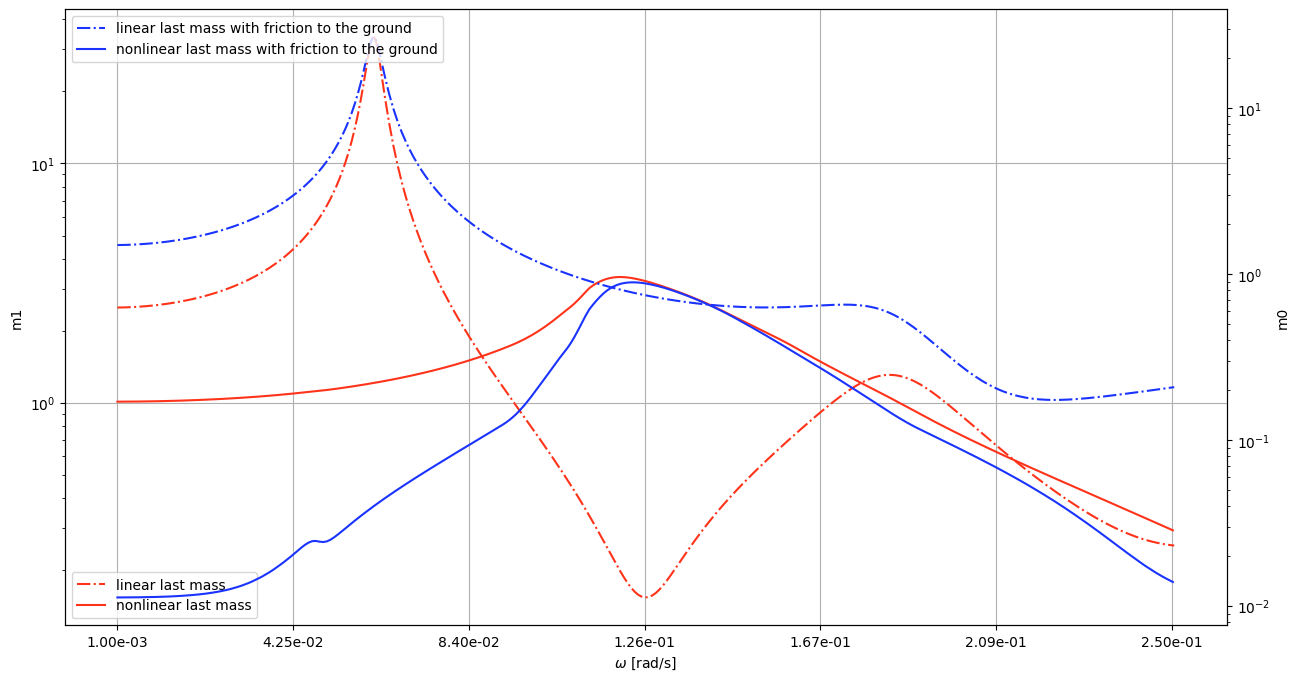

In [12]:
Lres_m1 = get_frf(L, sub='sub', node=Ntot_masses-1)
Lres_m0 = get_frf(L, sub='sub', node=N_masses-1) # The inversion IS normal here
NLres_m1 = get_frf(NL, sub='sub', node=Ntot_masses-1)
NLres_m0 = get_frf(NL, sub='sub', node=N_masses-1) # The inversion IS normal here

Lplt = dict(linestyle='-.', label='linear')
NLplt = dict(linestyle='-', label='nonlinear')
m1plt = dict(color=(1.0, 0.2, 0.1), label='last mass')
m0plt = dict(color=(0.1, 0.2, 1.0), label='last mass with friction to the ground')
thresholdplt = dict(linestyle='--', linewidth=2, color=(0.0, 0.0, 0.0), label='gap threshold')

fig,ax = prep_fig(fp=np.linspace(PULS_INF, PULS_SUP,7))
ax_m0 = ax.twinx()
ax.plot(*Lres_m1, **build_style(Lplt, m1plt))
ax_m0.plot(*Lres_m0, **build_style(Lplt, m0plt))
ax.plot(*NLres_m1, **build_style(NLplt, m1plt))
ax_m0.plot(*NLres_m0, **build_style(NLplt, m0plt))
ax.legend(loc=3)
ax_m0.legend(loc=2)
ax.set_ylabel('m1')
ax_m0.set_ylabel('m0')
ax.set_xlabel('$\omega$ [rad/s]')
ax.set_yscale('log')
ax_m0.set_yscale('log')

In [13]:



export_sol(L, path=f"./{NAME_STUDY}", prefix=f"linear")
export_sol(NL, path=f"./{NAME_STUDY}", prefix=f"nonlinear")